In [30]:
import sys, os
from pyprojroot import here


# spyder up to find the root
# root = here(project_files=[".here"])

local = here(project_files=[".root"])

# append to path
# sys.path.append(str(root))
sys.path.append(str(local))

In [31]:
import xarray as xr
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from tqdm.notebook import tqdm, trange
from kernellib.types import GeoData, Dimensions
from kernellib.kernels import SpatioTemporalKernel
from kernellib.data.oi import reformat_oi_output
from kernellib.features.oi import create_oi_grid
from kernellib.data.l3 import read_l3_data
from kernellib.data.l4 import read_l4_data
from kernellib.features.interp import interp_on_alongtrack
from kernellib.features.config import load_test_aoi
import hvplot.xarray
from pathlib import Path
import wandb

%load_ext autoreload
%autoreload 2
# %load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config

In [32]:
!ls /mnt/meom/workdir/johnsonj
# !ls /bettik/johnsonj/data/data_challenges/ssh_mapping_2021/interim

data  logs


In [33]:
from kernellib.data.files import files_factory
from kernellib.data.io import load_multiple_data
from kernellib.features.aoi import aoi_factory, subset_data
from kernellib.features.oi import oi_params_factory, create_oi_grid
from kernellib.features.space import correct_lon
from kernellib.features.time import add_vtime

In [34]:
import hydra
import omegaconf

In [91]:
with hydra.initialize(config_path="../config/"):
    # 
    # config = hydra.compose(config_name="main.yaml")
    config = hydra.compose(
        config_name="main.yaml", 
        overrides=[
            'aoi=smoketest', 
            "experiment=baseline",
            "model.kernel.kernel_fn='rbf'"
        ])

In [92]:
config
# config.server

{'ds_oi_grid': '_null_', 'oi_grid': {'_target_': 'kernellib.features.oi.create_oi_grid', 'lon_min': '${aoi.lon_min}', 'lon_max': '${aoi.lon_max}', 'dlon': '${aoi.dlon}', 'lat_min': '${aoi.lat_min}', 'lat_max': '${aoi.lat_max}', 'dlat': '${aoi.dlat}', 'time_min': '${aoi.time_min}', 'time_max': '${aoi.time_max}', 'dt_step': '${aoi.dt_step}', 'dt_period': '${aoi.dt_period}'}, 'load': {'_target_': 'kernellib.data.io.load_multiple_data', 'filenames': '${server.train_data_dir}'}, 'subset': {'_target_': 'kernellib.features.aoi.subset_data', 'lon_min': '${aoi.lon_min}', 'lon_max': '${aoi.lon_max}', 'dlon': '${aoi.dlon}', 'lat_min': '${aoi.lat_min}', 'lat_max': '${aoi.lat_max}', 'dlat': '${aoi.dlat}', 'time_min': '${aoi.time_min}', 'time_max': '${aoi.time_max}', 'dt_step': '${aoi.dt_step}', 'dt_period': '${aoi.dt_period}', 'Lt': '${oi/Lt}', 'Lx': '${oi/Lx}', 'Ly': '${oi/Ly}', 'noise': '${oi/noise}'}, 'name': 'no_opt', 'project': 'gps4oi', 'entity': 'ige', 'server': {'train_data_dir': '/home/joh

In [76]:
def config_to_wandb(config):
    # convert config to dict
    config_ = omegaconf.OmegaConf.to_container(
            config, resolve=False, throw_on_missing=True
        )
    
    # remove intermediate dictionaries
    config_.pop("load")
    config_.pop("subset")
    return config_

In [77]:
# t = config_to_wandb(config)
# t

In [78]:
config

{'ds_oi_grid': '_null_', 'oi_grid': {'_target_': 'kernellib.features.oi.create_oi_grid', 'lon_min': '${aoi.lon_min}', 'lon_max': '${aoi.lon_max}', 'dlon': '${aoi.dlon}', 'lat_min': '${aoi.lat_min}', 'lat_max': '${aoi.lat_max}', 'dlat': '${aoi.dlat}', 'time_min': '${aoi.time_min}', 'time_max': '${aoi.time_max}', 'dt_step': '${aoi.dt_step}', 'dt_period': '${aoi.dt_period}'}, 'load': {'_target_': 'kernellib.data.io.load_multiple_data', 'filenames': '${server.train_data_dir}'}, 'subset': {'_target_': 'kernellib.features.aoi.subset_data', 'lon_min': '${aoi.lon_min}', 'lon_max': '${aoi.lon_max}', 'dlon': '${aoi.dlon}', 'lat_min': '${aoi.lat_min}', 'lat_max': '${aoi.lat_max}', 'dlat': '${aoi.dlat}', 'time_min': '${aoi.time_min}', 'time_max': '${aoi.time_max}', 'dt_step': '${aoi.dt_step}', 'dt_period': '${aoi.dt_period}', 'Lt': '${oi/Lt}', 'Lx': '${oi/Lx}', 'Ly': '${oi/Ly}', 'noise': '${oi/noise}'}, 'name': 'no_opt', 'project': 'gps4oi', 'entity': 'ige', 'server': {'train_data_dir': '/home/joh

In [39]:
config.aoi

{'lon_min': 295.0, 'lon_max': 305.0, 'dlon': 0.2, 'lat_min': 33.0, 'lat_max': 43.0, 'dlat': 0.2, 'time_min': '2017-01-01', 'time_max': '2017-01-31', 'dt_step': 1, 'dt_period': 'D'}

In [42]:
# wandb.init(config=file_params)
import omegaconf

In [46]:
wandb.init(project=config.project, entity=config.entity, dir=config.server.logs_dir, config=config_to_wandb(config))
# wandb.config.update(oi_params)
# wandb.config.update(aoi_params)
# wandb.config.update(gp_params)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (use `wandb login --relogin` to force relogin)


In [47]:
from kernellib.features.aoi import AOIParams
from kernellib.features.oi import OIParams

In [48]:
%%time
n_samples = 10
aoi_params = AOIParams().init_from_config(config.aoi)
oi_params = OIParams().init_from_config(config.oi)

ds_oi_grid = create_oi_grid(aoi_params, config.oi.n_samples)

# load data
ds_obs = load_multiple_data(config.server.train_data_dir)

# subset data
ds_obs = subset_data(ds_obs, aoi_params, oi_params)


/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 13321 times more chunks
  return self.array[key]
/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 13321 times more chunks
  return self.array[key]
/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 13321 times more chunks
  return self.array[key]
/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 13321 times more chunks
  return self.array[key]
/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWa

CPU times: user 46.3 s, sys: 1.69 s, total: 48 s
Wall time: 50 s


In [49]:
ds_obs = add_vtime(ds_obs, aoi_params.time_min)

## Models

In [93]:
import torch
import gpytorch
from kernellib.models.kernels import kernel_fn_factory, KernelParams
from kernellib.models.gps import gp_model_factory
from kernellib.models.utils import gp_batch_predict, gp_samples

In [94]:
# init kernel params
kernel_params = KernelParams().init_from_config(config.model.kernel)

kernel = kernel_fn_factory(kernel_params.kernel_fn, kernel_params)

# init gp params
model, likelihood = gp_model_factory(config.model, kernel)


In [95]:
n_batches_pred = 100

print("Starting Loop")

Starting Loop


In [101]:
def step(pbar):
    
    ind1 = np.where(
        (np.abs(ds_obs.time.values - ds_oi_grid.gtime.values[i_time]) < 2.0 * oi_params.Lt)
    )[0]
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs.latitude.values[ind1],
        lon=ds_obs.longitude.values[ind1],
        time=ds_obs.time.values[ind1],
        data=ds_obs.sla_unfiltered.values[ind1],
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time],
    )
    

    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()

    # ML MODEL
    train_x = torch.Tensor(obs_coords)[:1000]
    train_y = torch.Tensor(obs_data.data)[:1000]
    test_x = torch.Tensor(state_coords)#[:1000]
    
    pbar.set_description("Fitting GP Model...")
    model_fitted = model(train_x, train_y)

    pbar.set_description("Predictions...")
    y_mu, y_var = gp_batch_predict(model_fitted, likelihood, test_x, config.model.n_batches_pred)
    
    # samples
    pbar.set_description("Drawing Samples...")
    y_samples = gp_samples(model_fitted, likelihood, test_x, config.oi.n_samples)
    
    
    return y_mu, y_var, y_samples

In [102]:
for i_time in (pbar := trange(len(ds_oi_grid.gtime))):
    pbar.set_description_str(f"time: {i_time}")

    # get indices where there are observations
    pbar.set_description("Subsetting Data...")
    
    y_mu, y_std, y_samples = step(pbar)

#     ind1 = np.where(
#         (np.abs(ds_obs.time.values - ds_oi_grid.gtime.values[i_time]) < 2.0 * oi_params.Lt)
#     )[0]

#     n_obs = len(ind1)

#     # get observation data
#     obs_data = GeoData(
#         lat=ds_obs.latitude.values[ind1],
#         lon=ds_obs.longitude.values[ind1],
#         time=ds_obs.time.values[ind1],
#         data=ds_obs.sla_unfiltered.values[ind1],
#     )

#     # get state data
#     state_data = Dimensions(
#         lat=ds_oi_grid.fglat.values,
#         lon=ds_oi_grid.fglon.values,
#         time=ds_oi_grid.gtime.values[i_time],
#     )

#     # DATA KERNEL

#     state_coords = state_data.coord_vector()
#     obs_coords = obs_data.coord_vector()

#     # ML MODEL
#     train_x = torch.Tensor(obs_coords)[:1000]
#     train_y = torch.Tensor(obs_data.data)[:1000]
#     test_x = torch.Tensor(state_coords)#[:1000]
    

#     pbar.set_description("Fitting GP Model...")
#     model_fitted = model(train_x, train_y)

#     pbar.set_description("Predictions...")
#     y_mu, y_var = gp_batch_predict(model_fitted, likelihood, test_x, config.model.n_batches_pred)

#     # samples
#     pbar.set_description("Drawing Samples...")
#     y_samples = gp_samples(model_fitted, likelihood, test_x, config.oi.n_samples)

    # save into data arrays
    pbar.set_description("Putting in Data...")
    ds_oi_grid.gssh_mu[i_time, :, :] = y_mu.reshape(
        ds_oi_grid.lat.size, ds_oi_grid.lon.size
    )
    ds_oi_grid.gssh_var[i_time, :, :] = y_var.reshape(
        ds_oi_grid.lat.size, ds_oi_grid.lon.size
    )
    ds_oi_grid.gssh_samples[:, i_time, :, :] = y_samples.reshape(
        n_samples, ds_oi_grid.lat.size, ds_oi_grid.lon.size
    )
    ds_oi_grid.nobs[i_time] = n_obs



  0%|          | 0/31 [00:00<?, ?it/s]

In [90]:
ds_oi_grid.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

## GP Model

In [ ]:
# initialize kernel


# initialize mean functions


# initialize covariance function



# initialize gp model



# initialize gp model with training data




### Model I - ARD Kernel

In [15]:
gp_params = gp_model_factory(model="exact")
gp_params.length_scale = [oi_params.Lt, oi_params.Lx, oi_params.Ly]
model, likelihood = init_exact_gp(gp_params)

model = model(train_x, train_y)
with torch.no_grad():
    dist = model(train_x)
    cov_ard = dist.covariance_matrix.numpy()
model, likelihood

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)


(GPRegressionModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ConstantMean()
   (covar_module): RBFKernel(
     (raw_lengthscale_constraint): Positive()
     (distance_module): Distance()
   )
 ),
 GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 ))

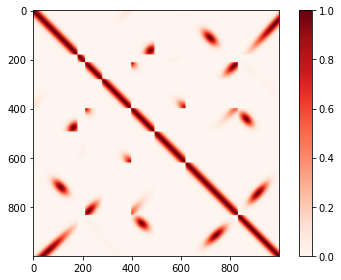

In [16]:
fig, ax = plt.subplots()

img = ax.imshow(cov_ard, cmap="Reds")
plt.colorbar(img)
plt.tight_layout()
plt.show()

### Model II - Spatio-Temporal Kernel (Product)

In [37]:
gp_params = gp_model_factory(model="exact")
gp_params.length_scale = [oi_params.Lt, oi_params.Lx, oi_params.Ly]
# model, likelihood = init_exact_gp(gp_params)
model, likelihood = init_exact_spatiotemp_gp(gp_params)
model = model(train_x, train_y)

with torch.no_grad():
    dist = model(train_x)
    cov_spatemp = dist.covariance_matrix.numpy()
model, likelihood

(GPRegressionModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ConstantMean()
   (covar_module): ProductKernel(
     (kernels): ModuleList(
       (0): RBFKernel(
         (raw_lengthscale_constraint): Positive()
         (distance_module): Distance()
       )
       (1): RBFKernel(
         (raw_lengthscale_constraint): Positive()
         (distance_module): Distance()
       )
     )
   )
 ),
 GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 ))

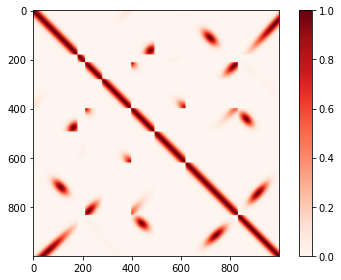

In [38]:
fig, ax = plt.subplots()

img = ax.imshow(cov_spatemp, cmap="Reds")
plt.colorbar(img)
plt.tight_layout()
plt.show()

### Model III - Spatio-Temporal Kernel (All Products)

In [ ]:
gp_params = gp_model_factory(model="exact")
gp_params.length_scale = [oi_params.Lt, oi_params.Lx, oi_params.Ly]
model, likelihood = init_exact_prod_gp(gp_params)
model = model(train_x, train_y)

with torch.no_grad():
    dist = model(train_x)
    cov_prod = dist.covariance_matrix.numpy()
model, likelihood

ERROR! Session/line number was not unique in database. History logging moved to new session 41


NameError: name 'cov_prod' is not defined

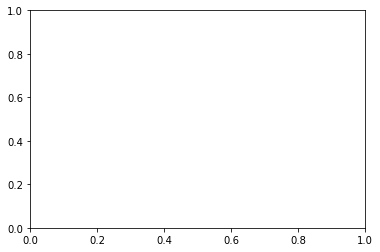

In [60]:
fig, ax = plt.subplots()

img = ax.imshow(cov_prod, cmap="Reds")
plt.colorbar(img)
plt.tight_layout()
plt.show()

In [39]:
dist.covariance_matrix

tensor([[1.0000, 0.9983, 0.9933,  ..., 0.0550, 0.0634, 0.0729],
        [0.9983, 1.0000, 0.9983,  ..., 0.0631, 0.0725, 0.0829],
        [0.9933, 0.9983, 1.0000,  ..., 0.0721, 0.0825, 0.0941],
        ...,
        [0.0550, 0.0631, 0.0721,  ..., 1.0000, 0.9980, 0.9920],
        [0.0634, 0.0725, 0.0825,  ..., 0.9980, 1.0000, 0.9980],
        [0.0729, 0.0829, 0.0941,  ..., 0.9920, 0.9980, 1.0000]],
       grad_fn=<MulBackward0>)

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [ ]:
# from dataclasses import dataclass, field
# from typing import Optional, List
# from kernellib.models.means import mean_fn_factory
# from kernellib.models.kernels import kernel_fn_factory
# from kernellib.models.exact import get_exact_gp
# from kernellib.models import gp_model_factory


# @dataclass
# class GPModel:
#     mean_fn: str = "constant"
#     kernel_fn: str = "rbf"
#     ard_dims: int = 3
#     length_scale: Optional[List[float]] = field(default_factory=list)
#     scale: bool = True
#     likelihood: str = "gaussian"
#     noise: int = 0.05
#     model: str = "exact"
    
#     def init_mean_fn(self):
#         return mean_fn_factory(self.mean_fn)
    
#     def init_kernel_fn(self):
#         # initialize kernel function
#         kernel = kernel_fn_factory(self.kernel_fn, self.ard_dims)
        
#         # set default lengthscale
#         kernel.lengthscale = self.length_scale

#         return kernel
    
#     def init_likelihood_fn(self):
#         # initialize likelihood function
#         likelihood = gpytorch.likelihoods.GaussianLikelihood()
#         # set noise level
#         likelihood.noise = self.noise
#         return likelihood
    
#     def init_gp_model(self, train_x, train_y):
#         # init likelihood, mean, kernel
#         likelihood = self.init_likelihood_fn()
#         mean = self.init_mean_fn()
#         kernel = self.init_kernel_fn()
        
#         # model init
#         model = gp_model_factory(self.model)(mean, kernel, likelihood)

        
#         return model(train_x, train_y), likelihood
    
    

In [ ]:
if smoke_test:
    SAVE_PATH = Path(file_params.results_dir).joinpath("OSE_ssh_mapping_BASELINE_test.nc")
else:
    SAVE_PATH = Path(file_params.results_dir).joinpath("OSE_ssh_mapping_BASELINE.nc")

# ML MODEL
ds_oi_grid.to_netcdf(file_params.results_dir)


In [ ]:
model

In [ ]:
%%time
from kernellib.models.utils import gp_batch_predict, gp_samples

y_mu, y_var = gp_batch_predict(model, likelihood, test_x, n_batches_pred)

In [ ]:
model